Previously, we identified patterns and trends that influence customer purchasing behavior. We will now perform PCA, and leverage its results together with k-means clustering to develop a customer segmentation model.

# **0. Import necessary packages and data**

## (a) Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

## (b) Import data

In [2]:
customer_behavior = pd.read_csv("C:/Users/tanmi/Downloads/cleaned_customer_behavior.csv")

## (c) Drop unnecessary columns

In [3]:
customer_behavior['date'] = pd.to_datetime(customer_behavior['date'])  # Ensure the column is in datetime format

# There are only two years (Aug 2016 to Aug 2017), so we drop year
customer_behavior['month'] = customer_behavior['date'].dt.month

In [4]:
# drop transactionRevenue since it is deprecated, drop numHits due to 0.98 correlation with pageviews as discussed in previous correlation analysis

customer_behavior.drop(columns=['transactionRevenue','numHits','brand','product_name','medium','source','subsub_category','subcontinent','country','region','sub_category','date','startTime'], inplace=True)

# brand has 18608504 datapoints not set. Almost whole dataset. product_name is a messy column similar to category
# medium and source are unrelated to customer purchasing behavior. Will be examined in detail in other parts of our analysis
# drop subsub_category due to dominating amount of Other, which does not value-add much to analysis and will make dataset very chunky when we do one-hot encoding

## (d) Fill NAs

In [5]:
# fill na

customer_behavior['main_category'] = customer_behavior['main_category'].fillna('Other')

In [6]:
columns_to_fill_2 = ['transactionId', 'timeOnSite','pageviews']

customer_behavior[columns_to_fill_2] = customer_behavior[columns_to_fill_2].fillna(0)

# **1. Encode & Standardize Data**

In [7]:
# drop transactionId, visitId only for pca
pca_data = customer_behavior.drop(['users','transactionId','visitId'],axis=1)

In [8]:
pca_data.columns

Index(['visitNumber', 'continent', 'action', 'timeOnSite', 'pageviews',
       'sessionQuality', 'totals_revenue', 'transactions', 'price',
       'impression', 'click', 'main_category', 'month'],
      dtype='object')

## (a) Standardize Data

- It is important to carefully standardize data before performing PCA as it works under the assumption that the data is **normal distributed**, and is very sensitive to the variance of the variables. Large differences between the ranges of variables will dominate over those with small ranges.

- We hence decide to implement the **z_score scaling** method.

In [9]:
cols_standardize = ['visitNumber','timeOnSite','pageviews','sessionQuality','totals_revenue','price']
scaler = StandardScaler()
pca_data[cols_standardize] = scaler.fit_transform(pca_data[cols_standardize])

In [10]:
# Encode month as cyclical using sine and cosine transformations since there seem to be spike in revenue in Aug
pca_data['month_sin'] = np.sin(2 * np.pi * pca_data['month'] / 12)
pca_data['month_cos'] = np.cos(2 * np.pi * pca_data['month'] / 12)

In [11]:
pca_data.drop(columns=['month'], inplace=True)

In [12]:
# Onehot Encode
categorical_features = ['main_category', 'continent', 'action']

pca_data = pd.get_dummies(pca_data, drop_first = True, columns = categorical_features)
pca_data.head()

,visitNumber,timeOnSite,pageviews,sessionQuality,totals_revenue,transactions,price,impression,click,month_sin,...,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,action_1,action_2,action_3,action_4,action_5,action_6
0,-0.156224,-0.658610,-0.649980,-0.147757,-0.066716,0.0,-0.106332,1,0,1.0,...,False,True,False,False,False,False,False,False,False,False
1,-0.156224,-0.061270,-0.463982,-0.147757,-0.066716,0.0,-0.349136,1,0,1.0,...,True,False,False,False,False,False,False,False,False,False
2,-0.156224,-0.315370,-0.463982,-0.147757,-0.066716,0.0,-0.002274,1,0,1.0,...,True,False,False,False,False,False,False,False,False,False
3,-0.156224,0.193854,-0.315184,-0.147757,-0.066716,0.0,-0.817054,1,0,1.0,...,True,False,False,False,False,False,False,False,False,False
4,-0.156224,0.193854,-0.315184,-0.147757,-0.066716,0.0,-0.002274,1,0,1.0,...,True,False,False,False,False,False,False,False,False,False


In [13]:
pca_data.columns

Index(['visitNumber', 'timeOnSite', 'pageviews', 'sessionQuality',
       'totals_revenue', 'transactions', 'price', 'impression', 'click',
       'month_sin', 'month_cos', 'main_category_Apparel', 'main_category_Bags',
       'main_category_Brands', 'main_category_Electronics',
       'main_category_Gift Cards', 'main_category_Kids',
       'main_category_Lifestyle', 'main_category_Limited Supply',
       'main_category_Office', 'main_category_Other', 'main_category_Sale',
       'continent_Africa', 'continent_Americas', 'continent_Asia',
       'continent_Europe', 'continent_Oceania', 'action_1', 'action_2',
       'action_3', 'action_4', 'action_5', 'action_6'],
      dtype='object')

# **2. PCA**

## (a) Perform PCA

(i) Check for NA in data

In [14]:
#pca doesn't work with NA. Check if data is good to go.WindowsError

pca_data.isna().sum()

visitNumber                     0
timeOnSite                      0
pageviews                       0
sessionQuality                  0
totals_revenue                  0
transactions                    0
price                           0
impression                      0
click                           0
month_sin                       0
month_cos                       0
main_category_Apparel           0
main_category_Bags              0
main_category_Brands            0
main_category_Electronics       0
main_category_Gift Cards        0
main_category_Kids              0
main_category_Lifestyle         0
main_category_Limited Supply    0
main_category_Office            0
main_category_Other             0
main_category_Sale              0
continent_Africa                0
continent_Americas              0
continent_Asia                  0
continent_Europe                0
continent_Oceania               0
action_1                        0
action_2                        0
action_3      

(ii) Create PCA pipeline and run accordingly

In [15]:
# Apply PCA
pca = PCA(n_components=5)  # Choose the number of components you want
pca_results = pca.fit(pca_data)

# Access PCA loadings
pca_loadings = pca.components_
print("PCA Loadings Shape:", pca_loadings.shape)  # Shape will be (n_components, number of features)
print("PCA Loadings:", pca_loadings)

PCA Loadings Shape: (5, 33)
PCA Loadings: [[ 2.00302327e-01  6.32512239e-01  6.38747030e-01  1.40196636e-01
   3.06137616e-01  1.64632143e-01  2.07651372e-02 -3.35530940e-02
   5.49221877e-03 -5.23418632e-02 -9.75258630e-03  8.16410278e-03
   1.03882941e-03 -4.21771821e-02 -4.00173621e-05  7.67075054e-05
   1.01249941e-04  3.57019236e-03  1.76777671e-04  1.33303136e-02
   1.09198831e-02  1.31069352e-04 -1.31354826e-03  5.49944700e-02
  -1.84688410e-02 -3.22036186e-02 -2.85668004e-03  5.49221877e-03
   4.26303591e-03  3.10630235e-03  6.50120235e-04  1.63595149e-02
   3.68190183e-03]
 [ 3.65603261e-01 -1.18741622e-01 -1.08268833e-01 -3.70312375e-01
   3.60883121e-01  4.99378970e-03  7.34730703e-01 -5.95135886e-03
   2.23224118e-03  6.80948267e-02  1.26585287e-01  9.09379173e-02
   2.70764854e-02 -1.31238141e-02  2.11367814e-02  2.06869063e-03
  -6.16425643e-05 -1.24046495e-02  1.66457072e-03 -4.88655636e-02
  -1.82072332e-02 -6.02421938e-04 -8.74606543e-05  6.10299686e-03
  -4.03645329e-

(iii) Visualise Data

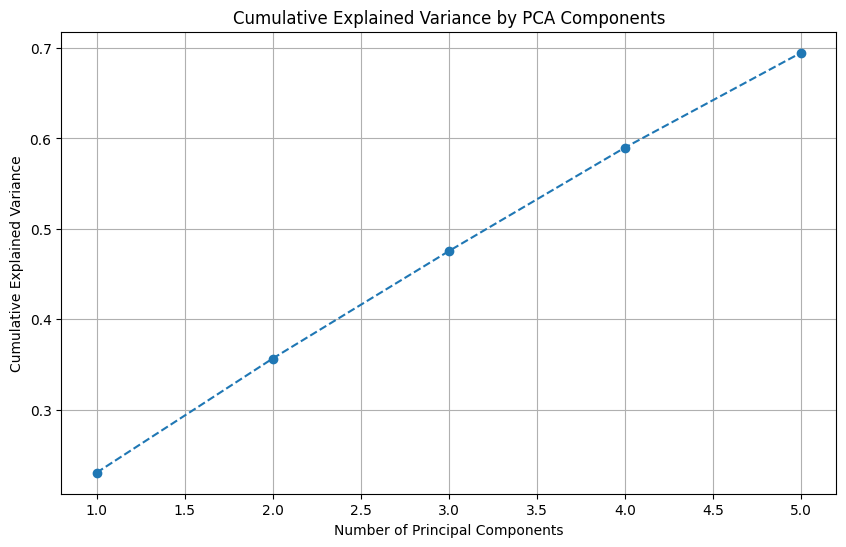

In [16]:
# Explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

- PCA does not seem to be performing well on this dataset since all 5 of our PC only explained ~70% variance of the whole dataset in total
- However, it is worth exploring which features in the original dataset contributes to the 5 of our PCs
- Identify features that contribute to most correlation to each PC to aid training of k-means clustering model in the later stage
- When performing k-means clustering, we can focus on the features identified

(iv) Closer look

In [17]:
# Explained variance by each principal component
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f'Principal Component {i+1}: {variance * 100:.2f}% variance explained')

Principal Component 1: 23.04% variance explained
Principal Component 2: 12.62% variance explained
Principal Component 3: 11.87% variance explained
Principal Component 4: 11.44% variance explained
Principal Component 5: 10.49% variance explained


This further confirms our observation from the plot above.

In [18]:
# Example original feature names (33 original features)
original_feature_names = pca_data.columns

# Create a DataFrame to map PCA loadings to original feature names
loadings_df = pd.DataFrame(pca_loadings, columns=original_feature_names, index=[f'PC{i+1}' for i in range(5)])

# Display the DataFrame
print(loadings_df)

     visitNumber  timeOnSite  pageviews  sessionQuality  totals_revenue  \
PC1     0.200302    0.632512   0.638747        0.140197        0.306138   
PC2     0.365603   -0.118742  -0.108269       -0.370312        0.360883   
PC3    -0.073077   -0.099130  -0.130055        0.866447        0.070991   
PC4     0.789720   -0.156912  -0.225184        0.202125        0.232104   
PC5    -0.435628   -0.191887  -0.076650       -0.017120        0.833139   

     transactions     price  impression     click  month_sin  ...  \
PC1      0.164632  0.020765   -0.033553  0.005492  -0.052342  ...   
PC2      0.004994  0.734731   -0.005951  0.002232   0.068095  ...   
PC3     -0.001041  0.422321   -0.017917  0.004512  -0.058608  ...   
PC4     -0.032771 -0.439454    0.008801 -0.004338   0.007137  ...   
PC5      0.095484 -0.236893   -0.003672 -0.003499   0.054357  ...   

     continent_Americas  continent_Asia  continent_Europe  continent_Oceania  \
PC1            0.054994       -0.018469         -0.032

In [21]:
# Iterate over the first 5 principal components
for i in range(5):  # PC1 to PC5
    for j in range(len(col_names)):  # Iterate over features
        # Use .iloc to access the loading value for the specific PC and feature
        coefficient = loadings_df.iloc[i, j]  # Get the coefficient for PC(i+1)
        print(f'Coefficient of PC{i + 1}: {coefficient:.2f} for feature: {col_names[j]}')

Coefficient of PC1: 0.20 for feature: visitNumber
Coefficient of PC1: 0.63 for feature: timeOnSite
Coefficient of PC1: 0.64 for feature: pageviews
Coefficient of PC1: 0.14 for feature: sessionQuality
Coefficient of PC1: 0.31 for feature: totals_revenue
Coefficient of PC1: 0.16 for feature: transactions
Coefficient of PC1: 0.02 for feature: price
Coefficient of PC1: -0.03 for feature: impression
Coefficient of PC1: 0.01 for feature: click
Coefficient of PC1: -0.05 for feature: month_sin
Coefficient of PC1: -0.01 for feature: month_cos
Coefficient of PC1: 0.01 for feature: main_category_Apparel
Coefficient of PC1: 0.00 for feature: main_category_Bags
Coefficient of PC1: -0.04 for feature: main_category_Brands
Coefficient of PC1: -0.00 for feature: main_category_Electronics
Coefficient of PC1: 0.00 for feature: main_category_Gift Cards
Coefficient of PC1: 0.00 for feature: main_category_Kids
Coefficient of PC1: 0.00 for feature: main_category_Lifestyle
Coefficient of PC1: 0.00 for feature

(v) Inspection

Report features that contribute a high correlation to each PC. Threshold is coefficient that is not in (-0.2,0.2) 

**PC1:**

1. 0.20 for feature: visitNumber

2. 0.63 for feature: timeOnSite

3. 0.64 for feature: pageviews

**PC2:**

1. 0.37 for feature: visitNumber

2. -0.37 for feature: sessionQuality

3. 0.36 for feature: totals_revenue

4. 0.73 for feature: price

*Note: Session Quality seems to be contrasting visitNumber or totals_revenue*

**PC3:**

1. 0.87 for feature: sessionQuality

2. 0.42 for feature: price

**PC4:**

1. 0.79 for feature: visitNumber

2. -0.23 for feature: pageviews

3. 0.20 for feature: sessionQuality

4. 0.23 for feature: totals_revenue

5. -0.44 for feature: price

*Note: pageviews seems to be contrasting totals_revenue*

**PC5:**

1. -0.44 for feature: visitNumber

2. 0.83 for feature: totals_revenue

3. -0.24 for feature: price

*Note: visitNumber and price seems to contrast totals_revenue*

**Next Steps:**

In subsequent analysis, we will pay more attention to the features with larger coeff magnitude in each of the PCs, with decreasing priority from PC1 to PC5

# **3. k-means clustering**

(a) To start our k-means clustering, we define the number of clusters and fit k-means to the PCA-transformed data (focusing on the top contributing features)

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_kmeans_labels = kmeans.fit_predict(pca_data.iloc[:, :5])  # Using the first 5 PCs

(b) Add clustering labels

In [ ]:
pca_data['Cluster'] = pca_kmeans_labels

(c) Visualize the clusters using PC1 and PC2

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data.iloc[:, 0], y=pca_data.iloc[:, 1], hue=pca_kmeans_labels, palette="viridis", s=60, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Results (4 Clusters) on PCA-transformed Data')
plt.legend(title='Cluster', loc='best', bbox_to_anchor=(1, 1))
plt.show()

Observations:
- The clusters are fairly well-separated along the axes of PC1 and PC2, indicating distinct groupings in terms of customer behavior.
- Some clusters have a tighter distribution, suggesting those groups have more similar characteristics in PC1 and PC2 dimensions. 
- Others appear more dispersed, potentially indicating a wider variance in customer behavior within those segments.

Insights:
- Clusters that are more compact represent customers with similar purchasing patterns, while those more dispersed may contain subgroups with varying behaviors.
- Clusters that appear in opposite regions of PC1 and PC2 (e.g., high PC1, low PC2 vs. low PC1, high PC2) likely represent customer segments with contrasting behaviors.
- By identifying clusters, we can categorize customers into distinct segments, which helps to tailor marketing strategies, such as more advertisements for more engaged users, who are represented by segments with high values in PC1 (due to correlations with visitNumber, timeOnSite, and pageviews)

(d) Visualize the cluster centers for the selected features in the PCA space

In [ ]:
cluster_centers = kmeans.cluster_centers_
pca_center_df = pd.DataFrame(cluster_centers, columns=[f'PC{i+1}' for i in range(cluster_centers.shape[1])])

plt.figure(figsize=(12, 8))
sns.heatmap(pca_center_df.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'Cluster Center Value'})
plt.title("K-means Cluster Centers for PCA-transformed Features")
plt.xlabel("Cluster")
plt.ylabel("Principal Components")
plt.show()

Observations:
- Each cluster center exhibits different values across PCs, with some clusters having higher values in certain PCs and lower in others.
- For example, a cluster with high values in PC1 and PC2 might indicate users with frequent site visits, high session quality, and high spending, while a cluster with lower values in PC3 might reflect customers with lower transaction rates.
- Notable contrasts (positive and negative values) between clusters along the PCs reveal distinct behavioral patterns tied to features like timeOnSite, totals_revenue, sessionQuality, and price.

Insights:
- The heatmap’s differentiation along PCs helps identify distinct customer profiles, such as high-PC1, low-PC2 customers (frequent visitors with a relatively high session quality but moderate to low spending, as indicated by the negative correlation in sessionQuality on PC2) and high-PC3 customers (high-revenue clients with strong session quality but might not have high visit frequency).
- PC4 and PC5 show variance among clusters in relation to price, allowing us to identify cost-sensitive segments and premium buyers.
- Based on these insights, marketing campaigns can be designed to target clusters differently. For example, high-revenue clusters (high values in PCs related to revenue and session quality) could receive premium offers or loyalty benefits, while engaged but lower-spending customers could be targeted with conversion incentives or promotions.